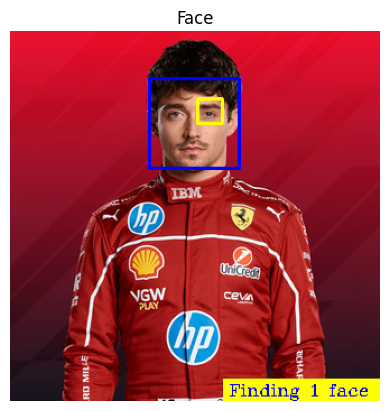

In [ ]:
# 人臉偵測
import cv2
import matplotlib.pyplot as plt

pictPath_face = r'C:\Users\q5j6j\miniconda3\envs\opencv-new\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml'
pictPath_lefteye = r'C:\Users\q5j6j\miniconda3\envs\opencv-new\Lib\site-packages\cv2\data\haarcascade_lefteye_2splits.xml'
face_cascade = cv2.CascadeClassifier(pictPath_face)
lefteye_cascade = cv2.CascadeClassifier(pictPath_lefteye)
# 建立辨識物件
img = cv2.imread("leclerc.png") 
# 讀取影像
faces = face_cascade.detectMultiScale(img, scaleFactor=1.1,
                                      minNeighbors=3, minSize=(20, 20))
lefteyes = lefteye_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=1, minSize=(5, 5))
 # 標註右下角底色是黃色
cv2.rectangle(img, (img.shape[1]-140, img.shape[0]-20),
              (img.shape[1], img.shape[0]), (0, 255, 255), -1)
 # 標註找到多少的人臉
cv2.putText(img, "Finding " + str(len(faces)) + " face",
            (img.shape[1]-135, img.shape[0]-5),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 0, 0), 1)
 # 將人臉框起來, 由於有可能找到好幾個臉所以用迴圈繪出來
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2) # 藍色框住人臉
    for (x1, y1, w1, h1) in lefteyes:
        cv2.circle(img, ((x1+w1/2), y1+h1/2), bg_cr, bg_color, bg_rw)
        cv2.(img, (x1, y1), (x1+w1, y1+h1), (0, 255, 0), 2) # 黃色框住人臉
cv2.imshow("Face", img) 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Face')
plt.axis('off')
# 顯示影像
cv2.waitKey(0)
cv2.destroyAllWindows()